# Setting

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def confusion2score(confusion):
    tp, fn, fp, tn = confusion.ravel()
    acc = (tp + tn) / (tp + fn + fp + tn)
    pre = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1  = (2 * tp) / (2*tp + fp + fn)
    return (acc, pre, rec, f1)

import spacy
from bs4 import BeautifulSoup

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [2]:
print('Pytorch version: ', torch.__version__)
print('Currently selected device: ', torch.cuda.current_device())
print('# GPUs available: ', torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu') # デバッグ用
print(device)

Pytorch version:  1.1.0
Currently selected device:  0
# GPUs available:  2
cuda:0


## Loading Data

In [3]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

# Preprocessing

## Tokenizer

In [4]:
spacy_en = spacy.load('en')
def tokenizer(text):
    soup = BeautifulSoup(text)
    clean_txt = soup.get_text()
    words = []
    for tok in spacy_en.tokenizer(clean_txt):
        if tok.text not in "[],.();:<>{}|*-~":
            words.append(tok.lemma_)
    return words

In [5]:
vocab = []
for text in train_df.body.values:
    vocab.extend(tokenizer(text))
vocab = list(set(vocab))
print('vocabulaly size: {}'.format(len(vocab)))
vocab_idx = dict(zip(vocab, range(len(vocab))))
del vocab

vocabulaly size: 16619


In [6]:
def df2indexseq(df, vocab_idx):
    data = []
    for text in df.values:
        words = tokenizer(text)
        data.append([vocab_idx[word]+1 for word in words if word in vocab_idx.keys()])
    return data

def padding(data):
    # npに変換し、0埋めを行う
    max_length = max([len(d) for d in data])
    padded_data = np.zeros((len(data), max_length))  # 0で埋める
    for i, d1 in enumerate(data):
        for j, d2 in enumerate(d1):
            padded_data[i][j] = d2
    return padded_data

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, tags):
        super(MyDataset, self).__init__()
        assert len(data) == len(tags)
        self.data = data
        self.tags = tags
        
    def __len__(self):
        return len(self.tags)
    
    def __getitem__(self, index):
        return self.data[index], self.tags[index]

In [7]:
X_train = torch.LongTensor(padding(df2indexseq(train_df.body, vocab_idx))).to(device)
y_train = torch.LongTensor(train_df.causal_flag.values).to(device)
X_test  = torch.LongTensor(padding(df2indexseq(test_df.body, vocab_idx))).to(device)
y_test  = torch.LongTensor(test_df.causal_flag.values).to(device)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)

# Model

## LSTM with self-attention

In [8]:
class ATT(nn.Module):
    def __init__(self, hidden_dim):
        super(ATT, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, inputs):
        b_size = inputs.size(0)
        inputs = inputs.contiguous().view(-1, self.hidden_dim)   # B,S,H*2 -> B*S,H*2
        att = self.fc(torch.tanh(inputs))  # B*S,H*2 -> B*S,1
        return F.softmax(att.view(b_size, -1), dim=1).unsqueeze(2) # (b*s, 1) -> (b, s, 1)

class LSTM(nn.Module):
    def __init__(self, batch_size, vocab_size, emb_dim, hidden_dim, dropout_rate=0.0, activate='tanh', bidirectional=False):
        super(LSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.emb_dim    = emb_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        self.activate   = activate
        
        self.emb  = nn.Embedding(self.vocab_size, self.emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first=True, bidirectional=self.bidirectional)
        self.att = ATT(hidden_dim * 2)
        
        self.fc0 = nn.Linear(hidden_dim * 2, 100)
        self.fc1 = nn.Linear(100, 2)
        self.do  = nn.Dropout(dropout_rate)
        
        self.hidden = self.init_hidden()

    def forward(self, x):

        x = self.emb(x)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        
        att = self.att(lstm_out)
        feats = (lstm_out * att).sum(dim=1) # (b, s, h) -> (b, h)
        
        y = self.fc0(feats)
        y = self.do(y)
        if self.activate == 'tanh':
            y = self.fc1(torch.tanh(y))
        elif self.activate == 'relu':
            y = self.fc1(torch.relu(y))
        tag_scores = F.log_softmax(y)
        return tag_scores, att

    def init_hidden(self):
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        num = 2 if self.bidirectional else 1    # bidirectionalのとき2
        h0 = torch.zeros(num, self.batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(num, self.batch_size, self.hidden_dim).to(device)
        return (h0, c0)

## Plot loss and acc

In [9]:
def training_plot(epoch_num, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    plt.figure()
    plt.plot(range(epoch_num), train_loss_list, color='blue', linestyle='-', label='train_loss')
    plt.plot(range(epoch_num), valid_loss_list, color='green', linestyle='--', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(epoch_num), train_acc_list, color='blue', linestyle='-', label='train_acc')
    plt.plot(range(epoch_num), valid_acc_list, color='green', linestyle='--', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('Training and validation accuracy')
    plt.grid()
    plt.show()

## Train and Valid

In [10]:
def training(net, train_loader, valid_loader, epoch_num, y_valid):
    train_loss_list = []
    train_acc_list  = []
    valid_loss_list = []
    valid_acc_list  = []

    for epoch in range(epoch_num):

        train_loss = 0.0
        train_acc  = 0.0
        valid_loss = 0.0
        valid_acc  = 0.0

        # train====================
        net.train()
        for xx, yy in train_loader:
            net.batch_size = len(yy)
            net.hidden = net.init_hidden()

            optimizer.zero_grad()    # 勾配の初期化

            output, att = net(xx)
            loss   = criterion(output, yy)

            train_loss += loss.item()
            train_acc += (output.max(1)[1] == yy).sum().item()

            loss.backward(retain_graph=True)     # 逆伝播の計算
            optimizer.step()    # 勾配の更新
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc  = train_acc  / len(train_loader.dataset)

        # eval========================
        net.eval()
        y_pred = np.zeros((1,2))
        with torch.no_grad():
            for xx, yy in valid_loader:
                net.batch_size = len(yy)
                net.hidden = net.init_hidden()

                output, att = net(xx)
                loss   = criterion(output, yy)

                valid_loss += loss.item()
                valid_acc  += (output.max(1)[1] == yy).sum().item()
                y_pred = np.concatenate([y_pred, output.to('cpu').numpy()], axis=0)
                
        avg_valid_loss = valid_loss / len(valid_loader.dataset)
        avg_valid_acc  = valid_acc  / len(valid_loader.dataset)
        
        if epoch in [49, 99, 199, 299]:
            confusion = confusion_matrix(y_valid, np.argmax(y_pred[1:,], axis=1).tolist())
            scores = confusion2score(confusion)
            print("At {} epoch, validation scores are...".format(epoch+1))
            print('Acc: {}, Precision: {}, Recall: {}, F1: {}'.format(avg_valid_acc, scores[1], scores[2], scores[3]))
            print('-----------')

        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        valid_loss_list.append(avg_valid_loss)
        valid_acc_list.append(avg_valid_acc)
        
    training_plot(epoch_num, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

## Test

In [19]:
from sklearn.metrics import roc_auc_score

def test(net, test_loader, y_test):
    net.eval()
    y_pred = np.zeros((1,2))
    with torch.no_grad():
        for xx, yy in test_loader:
            net.batch_size = len(yy)
            net.hidden = net.init_hidden()

            output, att = net(xx)
            y_pred = np.concatenate([y_pred, output.to('cpu').numpy()], axis=0)

    confusion = confusion_matrix(y_test, np.argmax(y_pred[1:,], axis=1).tolist())
    auc = roc_auc_score(y_test, np.argmax(y_pred[1:,], axis=1).tolist())
    scores = confusion2score(confusion)
    return [scores[0], scores[1], scores[2], scores[3]], confusion, auc

# Experiment

In [12]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

epoch_num  = 300     # エポック数
batch_size = 64      # バッチサイズ
vocab_size = len(vocab_idx)+1 # 語彙数
emb_dim    = 200     # 分散表現の次元数
hidden_dim = 100     # 隠れ層の次元数
drop_rate  = 0.0     # Dropout率
actiate    = 'relu'  # 活性化関数

learningrate = 0.01  # 学習率
weight_decay = 1e-3  # l2正則化

# dataloader(注意：validloader, testloaderのshuffleはFalse)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
# valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

net = LSTM(batch_size=batch_size, vocab_size=vocab_size, emb_dim=emb_dim, hidden_dim=hidden_dim, dropout_rate=drop_rate, activate=actiate, bidirectional=True).to(device)

# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
# optimizer = optim.Adam(net.parameters(), lr=learningrate, weight_decay=weight_decay)
optimizer = optim.SGD(net.parameters(), lr=learningrate, weight_decay=weight_decay)

print(net)

LSTM(
  (emb): Embedding(16620, 200, padding_idx=0)
  (lstm): LSTM(200, 100, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=200, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.0)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


At 50 epoch, validation scores are...
Acc: 0.8792786161207213, Precision: nan, Recall: 0.0, F1: 0.0
-----------
At 100 epoch, validation scores are...
Acc: 0.9470003680529996, Precision: 0.896551724137931, Recall: 0.6341463414634146, F1: 0.7428571428571429
-----------
At 200 epoch, validation scores are...
Acc: 0.9547294810452706, Precision: 0.8193146417445483, Recall: 0.801829268292683, F1: 0.810477657935285
-----------
At 300 epoch, validation scores are...
Acc: 0.9517850570482149, Precision: 0.8012232415902141, Recall: 0.7987804878048781, F1: 0.8
-----------


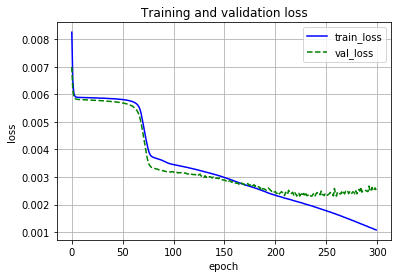

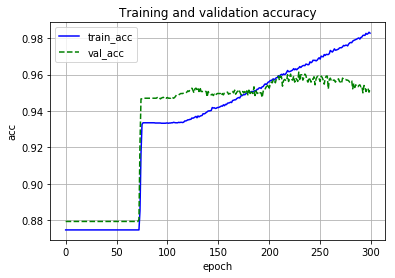

In [13]:
training(net, train_loader, test_loader, epoch_num, y_test.to('cpu').numpy())

In [20]:
result, confusion, auc = test(net, test_loader, y_test.to('cpu').numpy())
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))
print('auc: ', auc)
confusion

/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.9517850570482149, Precision: 0.8012232415902141, Recall: 0.7987804878048781, F1: 0.8
auc:  0.8857862254846911


array([[ 262,   66],
       [  65, 2324]])

In [53]:
print(len(train_df[train_df.causal_flag==0]))
print(len(train_df[train_df.causal_flag==1]))

1003
6997


## UnderSampling

In [15]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=2019)

X_train = padding(df2indexseq(train_df.body, vocab_idx))
y_train = train_df.causal_flag.values
X_train, y_train = sampler.fit_sample(X_train, y_train)
X_train = torch.LongTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test  = torch.LongTensor(padding(df2indexseq(test_df.body, vocab_idx))).to(device)
y_test  = torch.LongTensor(test_df.causal_flag.values).to(device)

train_ds = MyDataset(X_train, y_train)
test_ds  = MyDataset(X_test, y_test)

In [19]:
print(len(y_train))
print(len(y_train[y_train == 1]))

2006
1003


In [20]:
np.random.seed(2019)
np.random.RandomState(2019)
torch.manual_seed(2019)

epoch_num  = 300     # エポック数
batch_size = 64      # バッチサイズ
vocab_size = len(vocab_idx)+1 # 語彙数
emb_dim    = 200     # 分散表現の次元数
hidden_dim = 200     # 隠れ層の次元数
drop_rate  = 0.0     # Dropout率
actiate    = 'relu'  # 活性化関数

learningrate = 0.01  # 学習率
weight_decay = 1e-3  # l2正則化

# dataloader(注意：validloader, testloaderのshuffleはFalse)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
# valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

net = LSTM(batch_size=batch_size, vocab_size=vocab_size, emb_dim=emb_dim, hidden_dim=hidden_dim, dropout_rate=drop_rate, activate=actiate, bidirectional=True).to(device)

# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
# optimizer = optim.Adam(net.parameters(), lr=learningrate, weight_decay=weight_decay)
optimizer = optim.SGD(net.parameters(), lr=learningrate, weight_decay=weight_decay)

print(net)

LSTM(
  (emb): Embedding(16620, 200, padding_idx=0)
  (lstm): LSTM(200, 200, batch_first=True, bidirectional=True)
  (att): ATT(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
  (fc0): Linear(in_features=400, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
  (do): Dropout(p=0.0)
)


/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


At 50 epoch, validation scores are...
Acc: 0.5921972764078027, Precision: 0.16552315608919382, Recall: 0.5884146341463414, F1: 0.2583668005354752
-----------
At 100 epoch, validation scores are...
Acc: 0.42142068457857934, Precision: 0.15786578657865788, Recall: 0.875, F1: 0.2674743709226468
-----------
At 200 epoch, validation scores are...
Acc: 0.6010305483989694, Precision: 0.2004754358161648, Recall: 0.7713414634146342, F1: 0.3182389937106918
-----------
At 300 epoch, validation scores are...
Acc: 0.812661023187339, Precision: 0.37551581843191195, Recall: 0.8323170731707317, F1: 0.5175355450236967
-----------


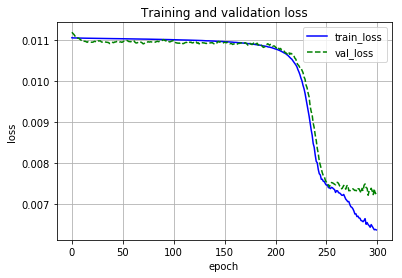

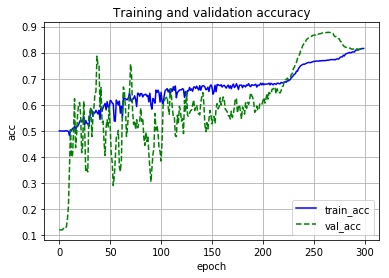

In [21]:
training(net, train_loader, test_loader, epoch_num, y_test.to('cpu').numpy())

In [23]:
result, confusion = test(net, test_loader, y_test.to('cpu').numpy())
print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(result[0], result[1], result[2], result[3]))
confusion

/home/b2018yniki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.812661023187339, Precision: 0.37551581843191195, Recall: 0.8323170731707317, F1: 0.5175355450236967


array([[ 273,   55],
       [ 454, 1935]])